# PSB better

This includes the correct ramp rate and SET feedback as well.

In [1]:
%matplotlib inline
import local_broom

Added 'quench/' and 'quench/libraries' for easy importing.


In [2]:
from zhinst.toolkit import Session, CommandTable, Sequence, Waveforms, SHFQAChannelMode

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from qcodes import Instrument, Station
import time
import warnings
from monty import Monty
import MDAC
from may.dots import getvoltages
from may.custom_devices import connect_to_gb, newSiDot
from liveplot import LivePlot
from fridge import Fridge
import swiper

from qcodes.instrument_drivers.oxford.MercuryiPS_VISA import MercuryiPS


## Setup

### Common Functions

In [3]:
def timeToSamples(time, samplingRateDivider):
    # returns the number of samples divisible by 16 given a time (in seconds) and sampling rate divider
    samples_raw = time * (1/(2**samplingRateDivider))/0.5e-9
    samples_modulo = int(samples_raw) % 16
    samples = int(samples_raw) - int(samples_modulo)
    return samples

# custom curve fit
#amps = [1, 0.85, 0.75, 0.65,  0.5, 0.35, 0.25, 0.2, 0.125, 0.05]
#voltages = [0.34, 0.268, 0.207, 0.158, 0.094, 0.0481,  0.026, 0.0183, 0.01, 0.0057]

#alt_fit = np.poly1d(np.polyfit(amps, voltages, 2))
# Hard coding alt_fit values in case something goes horribly wrong

def voltToDbm(volt, dbmrange):
    # Ok yes this can be better, deal with it
    if dbmrange != 0:
        raise Exception("This function only works with a dBm range of 0.")
    
    # if volt > 0.34 or volt < -0.34:
    #     raise ValueError(f"Given voltage ({volt} V) is greater than max output of SHFQC (0.34 V)")
    
    if volt < 0:
        amplitude = 1/300*(np.sqrt(3e5*-volt + 529) - 23)
        return -amplitude
    else:
        amplitude = 1/300*(np.sqrt(3e5*volt + 529) - 23)
        return amplitude


def autodb(res):
    """Change a.u. to dB power"""
    return 10*np.log10(np.abs(res)**2/50*1000)


def get_results(result_node, timeout):
    wave_data_captured = {}
    wave_data_captured[result_node] = False
    start_time = time.time()
    captured_data = {}
    while not all(wave_data_captured.values()):
        if start_time + timeout < time.time():
            print(captured_data)
            raise TimeoutError('Timeout before all samples collected.')
        test = session.poll()
        for node, value in test.items():
            node = session.raw_path_to_node(node)
            for v in value:
                if node not in captured_data:
                    captured_data[node] = [v['vector']]
                else:
                    captured_data[node].append(v['vector'])
            if len(captured_data[node]) >= 1:  # readout 1 point
                wave_data_captured[node] = True
                # total_num_data = sum([len(element) for element in captured_data[node]])
    data = captured_data[result_node][0]
    return data

def cmdtable(ct, amplitude, length, wave_index, ct_index):
    """
    Load a default command table with a sin/cos wave (used throughout the documentation)
    """
    ct.table[ct_index].waveform.index = wave_index
    ct.table[ct_index].amplitude00.value = amplitude  # all in dBm
    ct.table[ct_index].amplitude01.value = -amplitude
    ct.table[ct_index].amplitude10.value = amplitude
    ct.table[ct_index].amplitude11.value = amplitude
    ct.table[ct_index].waveform.length = length  # in samples
    ct.table[ct_index].waveform.samplingRateDivider = samplingDivider  # inherit global

### Connect

In [4]:
# connect to instruments

DEVICE_ID = 'DEV12158'
SERVER_HOST = 'localhost'

session = Session(SERVER_HOST)  # connect to data server
device = session.connect_device(DEVICE_ID)  # connect to device


try:
    mdac = Instrument.find_instrument("mdac")
    mdac.close()
except KeyError:
    print('Attempting to remove instrument with name mdac. Does not exist')

mdac = MDAC.MDAC('mdac', 'ASRL11::INSTR')

try:
    lockin = Instrument.find_instrument("sr860_top")
    lockin.close()
except KeyError:
    print("Cannot remove instrument with name sr860_top. Does not exist")

scfg = Station(config_file='/Users/LD2007/Documents/Si_CMOS_james/measurements/system.yaml')

lockin = scfg.load_instrument('sr860_top')



gb_control_si = connect_to_gb(mdac)  # Create our custom MDAC mappings
si = newSiDot(mdac)
fridge = Fridge("BlueFors_LD")
#magnet = MercuryiPS('magnet15', 'TCPIP0::192.168.0.106::7020::SOCKET')

Attempting to remove instrument with name mdac. Does not exist
Connected to: QNL Sydney MDAC (serial:0x32353532353551040030003E, firmware:1.8) in 4.21s
Cannot remove instrument with name sr860_top. Does not exist
Connected to: Stanford_Research_Systems SR860 (serial:004279, firmware:V1.51) in 0.11s
Loading GB driver and connecting
Manually Open Breakout_box_top_ch15_LCB
Manually Open Breakout_box_bot_ch09_RCB
Manually Open Breakout_box_bot_ch17_RG
Manually Open Breakout_box_top_ch17_ResB
Manually Open Breakout_box_top_ch19_P3
Manually Open Breakout_box_top_ch13_P2
Manually Open Breakout_box_top_ch04_P1
Manually Open Breakout_box_top_ch02_SETB
Manually Open Breakout_box_bot_ch04_SRB
Manually Open Breakout_box_bot_ch06_SLB
Manually Open Breakout_box_top_ch10_ST
Manually Open Breakout_box_top_ch25_bias
Using base URL https://qphys1114.research.ext.sydney.edu.au/therm_flask/BlueFors_LD


In [13]:
if False:
    session.disconnect_device(DEVICE_ID)
    try:
        mdac = Instrument.find_instrument("mdac")
        mdac.close()
    except KeyError:
        print('Attempting to remove instrument with name mdac. Does not exist')
    try:
        lockin = Instrument.find_instrument("sr860_top")
        lockin.close()
    except KeyError:
        print("Cannot remove instrument with name sr860_top. Does not exist")

In [14]:
if False:
    magnet._set_target_and_ramp('z', 'simul', 0.723)
    time.sleep(700) #ramping at approx 1mT/s

In [5]:
experiment = {
    "desc": "PSB sequence better version."
}

monty = Monty("rf.psb_better", experiment)

Loading existing experiment (ignoring given experiment parameters)
Note that no experimental data has been loaded.
Next run will have id 1


## DC Sweeps

In [6]:
def feedback(gate, lockin, target: float, stepsize=0.001, slope="up"):
    """
    Apply proportional feedback blindly
    """
    if slope == "up":
        sgn = 1
    elif slope == "down":
        sgn = -1
    else:
        raise (f"Unknown slope '{slope}'. Must be either 'up' or 'down'")

    r = lockin.R()
    error = (target - r) * sgn
    adjust = error / target * stepsize  # normalised error func
    g = gate() + adjust  # new gate voltage

    upperbound = 3.8
    lowerbound = 3.3

    if g > upperbound:  # upper bound
        print(f"Aborting feedback: correction voltage exceeds threshold, {g} > {upperbound}. No change to ST.")
    elif g < lowerbound:  # lower bound
        print(f"Aborting feedback: correction voltage fails to meet threshold, {g} < {lowerbound}. No change to ST.")
    #elif np.abs(r-target) > 0.03e-10:  # take a small step if good
    #    print(f"small step {np.abs(r-target)}")
    #    gate(gate() + adjust/4)
    #    time.sleep(0.5)
    else:
        gate(g)
        time.sleep(0.5)

def gettotarget():  # inherit global variables (bad!!!!)
    print(f"Target = {target:.4e}, tol = {tol}, initial ST = {si.ST()}")
    while np.abs(lockin.R()-target) > tol:
        feedback(si.ST, lockin, target, stepsize=0.001, slope="up")
        print(f"\rST = {si.ST():.4e}, lockin = {lockin.R():.4e}, delta = {np.abs(lockin.R()-target):.4e}", end="")
        time.sleep(0.1)
    print(f"\nFinal ST = {si.ST()}")

In [56]:
si.P1(1.725)
si.P2(2.0)

Started new run SET_ST_sweep.3
Sweeping Si28_quantum_dot_ST from 3.6V to 3.7V in 101 points.


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:41<00:00,  2.45it/s]


Run finished and took 0:00:46.408750.
Saving to SET_ST_sweep.3.xz
Saving to experiment.yaml


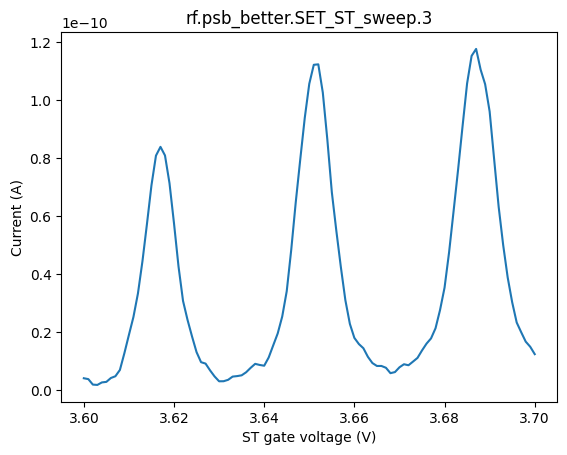

In [308]:
low = 3.6
high = 3.7
pts = 101

parameters = {
    "desc": "Quick 1D scan of the SET over ST",
    "ST":   f"range from {low}v -> {high}v, over {pts} pts",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    }

monty.newrun("SET ST sweep", parameters)
result = swiper.sweep1d(lockin, si.ST, low, high, pts, delay_time=0.3, monty=monty)  # overlap points so we average

monty.save(result)

In [309]:
si.ST(3.68)
target = 1e-10  # choose slightly on the right to match 
tol = 0.05e-10

gettotarget()

Target = 1.0000e-10, tol = 5e-12, initial ST = 3.680002
ST = 3.6821e+00, lockin = 9.7609e-11, delta = 2.3085e-12
Final ST = 3.682055


### Define variables

In [363]:

# lengths and averages
seq_averages = 1000  # seqc averages

NUM_DETUNING = 300  # 300
NUM_J = 1

# readout signals
readout_gain = 0.95  # If we set this to 1, then output overloads
readout_freq = 406.6e6  # (Hz), try 406.2

# drive line amplitudes (maximum 340mV, give in terms of V)
# pulse parameters
MIXED_AMP = {  # voltage amplitude for mixed state preperation
    "P1": -0.2,  # -0.2
    "P2": 0.2,  # 0.2
}
MES_AMP_START = {  # voltages for stepping over when sweeping
    "P1": 0.0,
    "P2": -0.0,
    "J": 0,
}
MES_AMP_END = {
    "P1": -0.04,
    "P2": 0.04,
    "J": 0.0,
}

# timings in seconds
init_len = 600e-6
read_len = 100e-6
wait_and_settle = 3e-3
trigger_time = 8e-3  # internal trigger holdoff time (metronome)
buffer = 10e-6

# AC decay ramp rate
ramp_rate = 13e-5  # V/sample

# powers
input_pwr = 0
output_pwr = -10
dr_pwr = 0

# gate sampling time
samplingDivider = 6

# feedback parameters
FB_TARGET = -24.1  # give in terms of power output
FB_STEPSIZE = 0#2e-2
FB_SLOPE = -1  # 1 or -1 depending on the slope to lock onto

# DC window setup
dc_p1_steps = np.linspace(1.725, 2.0, NUM_J)
dc_p2_steps = np.linspace(2.0, 1.725, NUM_J)
#dc_p2_steps = dc_p1_steps[::-1]

# internal
read_samples = timeToSamples(read_len, samplingDivider)
steps = np.logspace(-4.5, -2.5, NUM_J)

# DC voltages
#si.P1(1.745)
#si.P2(1.98)
# si.ST(3.655)

In [364]:
# adjust variables
curr_st_amp = 0.0  # NEED TO FIX THIS...

# Create channel maps for simplicity

chan = {
    "measure": device.qachannels[0],  # measure and acquire lines
    "ST": device.sgchannels[0],
    "P1": device.sgchannels[1],  # drive P1 line
    "P2": device.sgchannels[2],  # drive P2 line
    "J": device.sgchannels[3],  # drive J line
}

drive_chans = ["ST", "P1", "P2", "J"]  # match keys above

# current command tables
cts = {c: CommandTable(chan[c].awg.commandtable.load_validation_schema()) for c in drive_chans}

j_steps = np.linspace(MES_AMP_START["J"], MES_AMP_END["J"], NUM_J)
p1_steps = np.linspace(MES_AMP_START["P1"], MES_AMP_END["P1"], NUM_DETUNING)
p2_steps = np.linspace(MES_AMP_START["P2"], MES_AMP_END["P2"], NUM_DETUNING)

In [365]:
# save all the parameters about this experiment that we will want to know
params = {
    "amplitude_volts": {
        "mixed_pulse": MIXED_AMP,
        "measure_pulse_start": MES_AMP_START,
        "measure_pulse_end": MES_AMP_END,
        "ramp_rate": ramp_rate,
    },
    "dc_steps": {
        "start": p1_steps[0],
        "end": p1_steps[-1],
    },
    "readout": {
        "freq": readout_freq,
        "gain": readout_gain,
        "time": read_len
    },
    "timings_sec": {
        "mixed_initilise": init_len,
        "read": read_len,
        "settle": wait_and_settle,
        "trigger": trigger_time,
        "buffer": buffer,
        "sampling_divider": samplingDivider,
    },
    "feedback": {
        "target": FB_TARGET,
        "stepsize": FB_STEPSIZE,
        "slope": FB_SLOPE
    },
    "powers": {
        "acq_in": input_pwr,
        "acq_out": output_pwr,
        "drive": dr_pwr,
    },
    "averaging": {
        "seqc_averages": seq_averages,
        "num_detuning": NUM_DETUNING,
        "num_j": NUM_J,
    },
    "gates": getvoltages(mdac),
    "temp": f"Mixing chamber {fridge.temp()} K",
}

In [366]:
# check we can fit all the points into memory
MAX_MEASUREMENTS = 2**19
if seq_averages > MAX_MEASUREMENTS:
    raise OverflowError("Requested too many points to be measured. (Use around 500,000 points)")

### Configure Channels

In [367]:
with device.set_transaction():
    # setup drive channels
    for c in drive_chans:
        chan[c].output.range(dr_pwr)  # in dBm
        chan[c].output.rflfpath(0)  # use LF not RF (1 for RF)
    
        # set the center synth frequency (oscillator frequency)
        synth = chan[c].synthesizer()
        device.synthesizers[synth].centerfreq(0)  # in Hz
        chan[c].output.on(1)  # enable output
    
        chan[c].awg.outputamplitude(1.0)  # overall amplitude scaling factor (don't really need to change)
        chan[c].oscs[0].freq(0)  # oscillator 1 frequency (Hz) disable for DC
        chan[c].oscs[1].freq(0)  # oscillator 2 frequency (Hz)
        chan[c].awg.modulation.enable(1)  # start digital modulation
    
        chan[c].marker.source(0)  # setup the AWG trigger 1 (is this an input trigger option? doesn't seem necessary)
        # see manual page p235 for all trigger options
        chan[c].awg.auxtriggers[0].channel(8)  # 8=use internal trigger, 1024=use software trigger

    # setup measure channel
    
    chan["measure"].output.rflfpath(0)  # use LF mode not RF (for signals under 600Mhz)
    chan["measure"].input.rflfpath(0)
    chan["measure"].oscs[0].freq(readout_freq)  # CW frequency (in LF mode)
    chan["measure"].oscs[0].gain(readout_gain)  # If we set this to 1, then output overloads

    # configure these based on how the sweeper works internally
    # See https://docs.zhinst.com/zhinst-utils/en/latest/_modules/zhinst/utils/shf_sweeper.html#ShfSweeper
    chan["measure"].spectroscopy.delay(0)  # integration delay in units of second
    chan["measure"].spectroscopy.length(100e-6*2e9)#timeToSamples(read_len, 0))  # integration time length in units of number of samples (usually integration_time*sampling_rate)
    # setup when the spectroscopy is triggered
    chan["measure"].spectroscopy.trigger.channel("chan0seqtrig0")  # make sure to use the trigger coming from the sequencer code
    # setup result parameters
    chan["measure"].spectroscopy.result.averages(seq_averages)  # number of averages (always average in software not hardware)
    chan["measure"].spectroscopy.result.length(2)  # number of results
    chan["measure"].spectroscopy.result.enable(0)  # disable result logger
    chan["measure"].spectroscopy.result.mode('cyclic')  # sequential readout for averaging
    chan["measure"].spectroscopy.envelope.enable(0)  # changes into continuous mode

    chan["measure"].configure_channel(
        center_frequency=0,  # in units of Hz  # minimum of 600MHz for RF mode
        input_range=input_pwr,  # in units of dBm
        output_range=output_pwr,  # in units of dBm
        mode=SHFQAChannelMode.SPECTROSCOPY,  # SHFQAChannelMode.READOUT or SHFQAChannelMode.SPECTROSCOPY
    )
    
    chan["measure"].input.on(1)
    chan["measure"].output.on(1)

    chan["measure"].generator.auxtriggers[1].channel("inttrig")  # i believe this is overwritten by the following line
    chan["measure"].generator.configure_sequencer_triggering(
        aux_trigger=8,  # alternatively use 8=internal trigger, or "software_trigger0" to use the software triggering system
        play_pulse_delay=0
    )

    device.system.internaltrigger.repetitions(seq_averages)  # make sure that this matches how many pulses we are sending
    device.system.internaltrigger.holdoff(trigger_time)  # init_len + 2*wait_and_settle + 100e-6*2)  # how long to wait between retriggers (increments of 100ns)


### Define Sequences

*P1/P2 sequence explanation*: The sequence starts at a "home" point with 0 V on the P1/P2/J pulsing lines. After waiting for a trigger, the sequence will immediately go to it's initialisation point (executeTableEntry(0)) and wait for a set period of time (here: wait_and_settle, read_len). After a J pulse between wait_and_settle and read_len events P1 and P2 will be pulsed to an arbitrary point (executeTableEntry(1)) which is uploaded and updated every time in python after SET feedback has occured.

In [368]:
seqc_program_p1 = f"""
// Assign a single channel waveform to wave table entry 0

// Reset the oscillator phase
resetOscPhase();

repeat({seq_averages}) {{

    // Trigger the scope
    
    waitDigTrigger(1);

    setTrigger(1);
    setTrigger(0);
    
    executeTableEntry(0);                                                               // mixed state init.
    
    playZero({timeToSamples(wait_and_settle, samplingDivider)},  {samplingDivider});    // wait and settle
    playZero({timeToSamples(read_len, samplingDivider)},  {samplingDivider});           // read reference

    executeTableEntry(1);                                                               // read
    
    playZero({timeToSamples(wait_and_settle, samplingDivider)},  {samplingDivider});    // wait and settle
}}
"""

seqc_program_p2 = f"""
// Assign a single channel waveform to wave table entry 0

// Reset the oscillator phase
resetOscPhase();

repeat({seq_averages}) {{

    // Trigger the scope
    
    waitDigTrigger(1);

    setTrigger(1);
    setTrigger(0);
    
    executeTableEntry(0);                                                               // mixed state init.
    
    playZero({timeToSamples(wait_and_settle, samplingDivider)},  {samplingDivider});    // wait and settle
    playZero({timeToSamples(read_len, samplingDivider)},  {samplingDivider});           // read reference

    executeTableEntry(1);                                                               // read
    
    playZero({timeToSamples(wait_and_settle, samplingDivider)},  {samplingDivider});    // wait and settle
}}
"""

seqc_program_j = f"""
// Assign a single channel waveform to wave table entry 0
wave w_j = ones({timeToSamples(init_len, samplingDivider)});
assignWaveIndex(1,2, w_j, 0);

// Reset the oscillator phase
resetOscPhase();

repeat({seq_averages}) {{

    // Trigger the scope
    
    waitDigTrigger(1);

    setTrigger(1);
    setTrigger(0);
    
    playZero({timeToSamples(init_len, samplingDivider)},  {samplingDivider});           // mixed state init.
    playZero({timeToSamples(wait_and_settle, samplingDivider)},  {samplingDivider});    // wait and settle

    executeTableEntry(1);                                                               // read reference
    
    // playZero({timeToSamples(read_len, samplingDivider)},  {samplingDivider});           // read
    playZero({timeToSamples(wait_and_settle, samplingDivider)},  {samplingDivider});    // wait and settle
    playZero(32);    // wait and settle
}}
"""



seqc_program_st = f"""
// Assign a single channel waveform to wave table entry 0
wave w_st = ones({timeToSamples(wait_and_settle, 9)});
assignWaveIndex(1,2, w_st, 0);

repeat({seq_averages}) {{
    waitDigTrigger(1);
    
    playZero({timeToSamples(init_len, samplingDivider)},  {samplingDivider});
    playZero({timeToSamples(wait_and_settle-10*buffer, samplingDivider)},  {samplingDivider});
    //playZero({timeToSamples(buffer, samplingDivider)},  {samplingDivider});
    
    executeTableEntry(0);
}}
"""

In [369]:
seqc_program_prior_read = f"""
repeat({seq_averages}) {{
    waitDigTrigger(1);
    
    setTrigger(1);
    setTrigger(0);
}}
"""

readout_prog_code = f"""
setTrigger(0); // Set low as this starts the spectroscopy readout....

repeat({seq_averages}) {{
    waitDigTrigger(1);
    
    playZero(224); // lineup with SG trigger (224 samples = lines up with SG trigger);
    
    playZero({timeToSamples(init_len, samplingDivider)},  {samplingDivider});
    playZero({timeToSamples(wait_and_settle, samplingDivider)},  {samplingDivider});
    playZero({timeToSamples(buffer, samplingDivider)},  {samplingDivider});

    setTrigger(1);  // trigger the output. As this matches "chan0seqtrig0" the spectroscopy is started
    setTrigger(0);

    playZero({timeToSamples(read_len, samplingDivider)},  {samplingDivider});
    playZero({timeToSamples(buffer, samplingDivider)},  {samplingDivider});

    setTrigger(1);  // trigger the output. As this matches "chan0seqtrig0" the spectroscopy is started
    setTrigger(0);

    playZero({timeToSamples(buffer, samplingDivider)},  {samplingDivider});
    playZero({timeToSamples(wait_and_settle, samplingDivider)},  {samplingDivider});
    }}

"""

In [370]:
# create waveforms
default_amp = 0.01

# Create mixed state
samples = timeToSamples(init_len, samplingDivider)
#mixed_p = np.linspace(voltToDbm(0.34 - 0.34*samples*ramp_rate, 0), voltToDbm(0.34, 0), samples)
mixed_p = np.linspace(voltToDbm(0.34, 0), voltToDbm(0.34, 0), samples)  # not ramping this one for now


# Read pulse driver
samples = timeToSamples(read_len, samplingDivider)
# read_p = np.linspace(voltToDbm(default_amp, dr_pwr),
#                        voltToDbm(default_amp+default_amp*samples*ramp_rate, dr_pwr), samples)
read_p = np.linspace(voltToDbm(0.34 - 0.34*samples*ramp_rate, 0), voltToDbm(0.34, 0), samples)
# read_p = np.linspace(voltToDbm(0.34, 0), voltToDbm(0.34+ 0.34*samples*ramp_rate, 0), samples)

del samples

In [371]:
# upload drive code

# P1
seq = Sequence()
seq.code = seqc_program_p1
seq.waveforms = Waveforms()
seq.waveforms[0] = mixed_p
seq.waveforms[1] = read_p
chan["P1"].awg.load_sequencer_program(seq)
chan["P1"].awg.write_to_waveform_memory(seq.waveforms)
print(f"_________ {chan["P1"]} _________")
print(seq.code)

# P2
seq = Sequence()
seq.code = seqc_program_p2
seq.waveforms = Waveforms()
seq.waveforms[0] = mixed_p
seq.waveforms[1] = read_p
chan["P2"].awg.load_sequencer_program(seq)
chan["P2"].awg.write_to_waveform_memory(seq.waveforms)
print(f"_________ {chan["P2"]} _________")
print(seq.code)

# J
chan["J"].awg.load_sequencer_program(seqc_program_j)
print(f"_________ {chan["J"]} _________")
print(seqc_program_j)

# ST
chan["ST"].awg.load_sequencer_program(seqc_program_st)
print(f"_________ {chan["ST"]} _________")
print(seqc_program_st)

# upload wavevforms with sequence code as the memory must be allocated first

# upload measure code
#chan["measure"].generator.load_sequencer_program(readout_prog_code)
#chan["measure"].generator.load_sequencer_program(seqc_program_prior_read)

_________ /dev12158/sgchannels/1 _________

// Assign a single channel waveform to wave table entry 0

// Reset the oscillator phase
resetOscPhase();

repeat(1000) {

    // Trigger the scope
    
    waitDigTrigger(1);

    setTrigger(1);
    setTrigger(0);
    
    executeTableEntry(0);                                                               // mixed state init.
    
    playZero(93744,  6);    // wait and settle
    playZero(3120,  6);           // read reference

    executeTableEntry(1);                                                               // read
    
    playZero(93744,  6);    // wait and settle
}

_________ /dev12158/sgchannels/2 _________

// Assign a single channel waveform to wave table entry 0

// Reset the oscillator phase
resetOscPhase();

repeat(1000) {

    // Trigger the scope
    
    waitDigTrigger(1);

    setTrigger(1);
    setTrigger(0);
    
    executeTableEntry(0);                                                               // mixed state init

### Setup Command tables

In [372]:
# load mixed state command channels
for c in ["P1", "P2"]:
    cmdtable(cts[c],
             amplitude= voltToDbm(MIXED_AMP[c], chan[c].output.range()),
             length=timeToSamples(init_len, samplingDivider),
             wave_index=0,
             ct_index=0,
            )

## Run

### Run functions

In [373]:
def uploadcts():
    """Upload the command tables to the device"""
    for c in drive_chans:
        chan[c].awg.commandtable.upload_to_device(cts[c])

In [348]:
def synchchannels(chans):
    """Sync the given channels, unsyncing the rest. Assumes that the internal trigger and measure channel should always be synced."""
    for i in range(6):
        device.sgchannels[i].synchronization.enable(0)
    time.sleep(1)
    for c in drive_chans:
        if c in chans:  # sync
            chan[c].synchronization.enable(1)
    chan["measure"].synchronization.enable(1)
    device.system.internaltrigger.synchronization.enable(1)

In [349]:
def waitForInternalTrigger(progress=True, leave=True):
    """
    Waits for the internal trigger to finish running and shows the current progress.
    Progress = if show tqdm progress meter
    Leave = if keep progress bar afterwards
    """
    if progress:
        pbar = tqdm(total=100, leave=leave, desc="Internal trigger")
    while device.system.internaltrigger.progress() != 1.0:
        p = int(device.system.internaltrigger.progress()*100)
        if progress:
            pbar.update(p-pbar.n)
        time.sleep(0.001)
    if progress:
        pbar.update(100-pbar.n)
        pbar.close()

In [350]:
def calculatefeedbackalt(data):
    """Calculate the appropriate feedback adjustment to ST."""
    # use last datapoint
    global curr_st_amp
    error = FB_TARGET - 10*np.log10(np.abs(data[-1])**2/50*1000)
    curr_st_amp += error*FB_STEPSIZE*FB_SLOPE

    # update command table
    cmdtable(cts["ST"],
             amplitude= voltToDbm(curr_st_amp, chan["ST"].output.range()),
             length=timeToSamples(trigger_time-2e-3, 9),
             wave_index=0,
             ct_index=0,
            )
    return curr_st_amp

def calculatefeedback(data):
    """Calculate the appropriate feedback adjustment to ST."""
    # use last datapoint
    unit_amp = 0.34
    error = FB_TARGET - 10*np.log10(np.abs(data[-1])**2/50*1000)
    st_err = error*FB_STEPSIZE*FB_SLOPE
    st_err = -1 if st_err < -1 else (1 if st_err > 1 else st_err)
    st_corr = st_err*unit_amp

    # update command table
    cmdtable(cts["ST"],
             amplitude= voltToDbm(st_corr, chan["ST"].output.range()),
             length=timeToSamples(trigger_time-2e-3, 9),
             wave_index=0,
             ct_index=0,
            )
    return st_corr

In [351]:
def movemeasurement(p1, p2, j):
    """Move P1/P2/J to measure the next appropriate datapoint."""
    cmdtable(cts["P1"],
             amplitude=voltToDbm(p1, chan["P1"].output.range()),
             length=timeToSamples(buffer + read_len + buffer, samplingDivider),
             wave_index=1,
             ct_index=1,
            )
    cmdtable(cts["P2"],
             amplitude=voltToDbm(p2, chan["P2"].output.range()),
             length=timeToSamples(buffer + read_len + buffer, samplingDivider),
             wave_index=1,
             ct_index=1,
            )
    cmdtable(cts["J"],
             amplitude= voltToDbm(j, chan["J"].output.range()),
             length=timeToSamples(buffer + read_len + buffer + read_len, samplingDivider),     # THIS LINE IS WRONG, FIX
             wave_index=0,
             ct_index=1,
            )
    

In [352]:
voltToDbm(0.34, chan["P2"].output.range())

0.9906716635319219

#### Experiment functions

In [353]:
def runfeedback():
    """Run feedback measurement where we only measure"""
    device.system.internaltrigger.enable(0)

    result_node = chan["measure"].spectroscopy.result.data.wave
    result_node.subscribe()
    
    chan["measure"].spectroscopy.result.enable(1)  # start logger
    chan["measure"].generator.enable_sequencer(single=True)
    device.system.internaltrigger.enable(1)
    
    time.sleep(0.2)  # delay for networking issues
        
    # wait for the measurement to complete
    waitForInternalTrigger()
    
    m_state = chan["measure"].generator.sequencer.status()
    if m_state != 4:
        warnings.warn(f"Sequencers in unknown state. Perhaps they are not synchronised? {bin(m_state)}")
        time.sleep(0.5)
    
    # wait for completion
    while chan["measure"].spectroscopy.result.enable() != 0:
        print(chan["measure"].spectroscopy.result.enable())
        chan["measure"].spectroscopy.result.enable.wait_for_state_change(0, timeout=10)
    
    # get results
    results = get_results(result_node, timeout=5)
    result_node.unsubscribe()
    
    # verify results
    acq = chan["measure"].spectroscopy.result.acquired()
    if len(results) > acq:
        print(chan["measure"].generator.ready())
        raise TimeoutError(f"Not all datapoints measured in the time provided. {acq} of {len(results)}.")

    return results
    

In [354]:
def runexperiment():
    device.system.internaltrigger.enable(0)

    result_node = chan["measure"].spectroscopy.result.data.wave
    result_node.subscribe()
    
    chan["measure"].spectroscopy.result.enable(1)  # start logger
    
    
    # start sequencers
    chan["measure"].generator.enable_sequencer(single=True)
    chan["J"].awg.enable_sequencer(single=True)  # dont want to repeat
    chan["P1"].awg.enable_sequencer(single=True)
    chan["P2"].awg.enable_sequencer(single=True)
    chan["ST"].awg.enable_sequencer(single=True)
    
    
    # start triggering sequence (which starts each sequencer)
    device.system.internaltrigger.enable(1)
    time.sleep(0.2)
    
    # wait for the measurement to complete
    waitForInternalTrigger(progress=True, leave=False)
    #device.system.internaltrigger. .wait_for_state_change(1.0, timeout=100)  # wait for completion


    # check sequencers have finished their sequences
    # Status of the Sequencer on the instrument.
    # - Bit 0: Sequencer is running;
    # - Bit 1: reserved;
    # - Bit 2: Sequencer is waiting for a trigger to arrive;
    # - Bit 3: Sequencer has detected an error;
    # - Bit 4: sequencer is waiting for synchronization with other channels
    m_state = chan["measure"].generator.sequencer.status()
    st_state = chan["P1"].awg.sequencer.status()
    if m_state != 4 and st_state != 4:
        warnings.warn(f"Sequencers in unknown state. Perhaps they are not synchronised? {bin(m_state)}, {bin(st_state)}")
        #time.sleep(0.5)
    
    
    # wait for completion
    while chan["measure"].spectroscopy.result.enable() != 0:
        chan["measure"].spectroscopy.result.enable.wait_for_state_change(0, timeout=100)

    
    # get results
    results = get_results(result_node, timeout=5)
    result_node.unsubscribe()
    
    
    # verify results
    acq = chan["measure"].spectroscopy.result.acquired()
    if len(results) > acq:
        print(chan["measure"].generator.ready())
        print([chan[c].awg.ready() for c in drive_chans])
        raise TimeoutError(f"Not all datapoints measured in the time provided. {acq} of {len(results)}.")
    
    #return np.mean(results.reshape((seq_averages, 2)), axis=0)
    return results




### Run loop

In [355]:
monty.runname

'sequence.37'

#### Sweep J and Detuning

In [356]:
def sweep_j_and_detuning():
    monty.newrun("sequence", params)

    # work out what we should be doing for feedback
    print("Measuring initial feedback point")
    with device.set_transaction():
        synchchannels([])
        chan["measure"].spectroscopy.result.length(1)
        chan["measure"].generator.load_sequencer_program(seqc_program_prior_read)
    
    time.sleep(1)
    chan["measure"].spectroscopy.result.length.wait_for_state_change(1, timeout=10)  # wait for changes to propagate
    
    data = runfeedback()
    
    with device.set_transaction():
        synchchannels(["P1", "P2", "J", "ST"])
        chan["measure"].generator.load_sequencer_program(readout_prog_code)
        chan["measure"].spectroscopy.result.length(2)
    time.sleep(2)
    
    result = np.zeros((NUM_J, NUM_DETUNING, 2), dtype=np.complex64)
    st_result = np.zeros(result.shape, dtype=np.float64)
    
    print("Sweeping P1, P2 and J")
    for i, j in enumerate(tqdm(j_steps, desc="J")):
        #with LivePlot(p1_steps, xlabel="P1 voltage (dV)", ylabel="Amplitude (dB)") as lplot: 
        # FB_STEPSIZE = steps[i]  # adjust the stepsize
        # curr_st_amp = 0.0  # reset feedback between runs (as j is not varied)
        
        for k, (p1, p2) in enumerate(zip(tqdm(p1_steps, leave=False, desc="Detuning"), p2_steps)):
            movemeasurement(p1, p2, j)  # CT = 1
            st_result[i, k] = calculatefeedback(data)  # CT = 0
            uploadcts()
            data = runexperiment()
            result[i, k] = data
            #lplot.update(autodb(result[i, :, 1]))
        monty.snapshot({"data": result, "st_result": st_result})
    
    monty.save({"data": result, "st_result": st_result})

#sweep_j_and_detuning()

#### Change window of detuning

In [357]:
def sweep_detuning_window():
    monty.newrun("window detuning", params)
    
    # work out what we should be doing for feedback
    print("Measuring initial feedback point")
    with device.set_transaction():
        synchchannels([])
        chan["measure"].spectroscopy.result.length(1)
        chan["measure"].generator.load_sequencer_program(seqc_program_prior_read)
    
    time.sleep(1)
    chan["measure"].spectroscopy.result.length.wait_for_state_change(1, timeout=10)  # wait for changes to propagate
    
    data = runfeedback()
    
    with device.set_transaction():
        synchchannels(["P1", "P2", "J", "ST"])
        chan["measure"].generator.load_sequencer_program(readout_prog_code)
        chan["measure"].spectroscopy.result.length(2)
    time.sleep(2)
    
    result = np.zeros((NUM_J, NUM_DETUNING, 2), dtype=np.complex64)
    st_result = np.zeros(result.shape, dtype=np.float64)
    
    print("Sweeping P1, P2 and J")
    for i, j in enumerate(tqdm(j_steps, desc="J")):
        #with LivePlot(p1_steps, xlabel="P1 voltage (dV)", ylabel="Amplitude (dB)") as lplot: 
    
        # adjust DC window
        si.P1(dc_p1_steps[i])
        si.P2(dc_p2_steps[i])
        time.sleep(2)
        gettotarget()
        time.sleep(1)
        
        for k, (p1, p2) in enumerate(zip(tqdm(p1_steps, leave=False, desc="Detuning"), p2_steps)):
            movemeasurement(p1, p2, j)  # CT = 1
            #st_result[i, k] = calculatefeedback(data)  # CT = 0
            uploadcts()
            data = runexperiment()
            result[i, k] = data
            #lplot.update(autodb(result[i, :, 1]))
        monty.snapshot({"data": result, "st_result": st_result})
    
    monty.save({"data": result, "st_result": st_result})

In [358]:
gettotarget()
time.sleep(1)

sweep_detuning_window()

Target = 1.0000e-10, tol = 5e-12, initial ST = 3.682114

Final ST = 3.682114
Started new run window_detuning.3
Measuring initial feedback point


Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Process data

In [ ]:
# reload saved data

result = monty.loadrun("sequence.4")["data"]

In [ ]:
result

In [ ]:
ref = result[:, :, 0]
mes = result[:, :, 1]

ref_amp = 10*np.log10(np.abs(ref)**2/50*1000)
ref_phase = np.unwrap(np.angle(ref))  # add axis for unwrap?

mes_amp = 10*np.log10(np.abs(mes)**2/50*1000)
mes_phase = np.unwrap(np.angle(mes))  # add axis for unwrap?

In [ ]:
# plot ST feedback history

# convert "voltage" to dB
#st_result = voltToDbm(st_result, chan["ST"].output.range())

# plot the first sweep in J only
plt.plot(p1_steps, st_result[0])
plt.xlabel("P1 voltage (V)")
plt.ylabel("ST amplitude (a.u.)")
plt.title(monty.identifier + "." + monty.runname + ".st")
monty.savefig(plt, "st_history")


In [ ]:
# plot the FIRST reference measurement

fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)

ax0.plot(p1_steps, ref_amp[0], ".-", color="steelblue")
ax1.plot(p1_steps, ref_phase[0], ".-", color="orange")
ax0.set_ylabel("Amplitude")
ax1.set_ylabel("Phase")
ax0.set_title(monty.identifier + "." + monty.runname + ".reference.1st")
ax1.set_xlabel("P1 voltage")

ax0.grid()
ax1.grid()
fig.align_ylabels([ax0, ax1])
plt.tight_layout()

monty.savefig(plt, "reference_1st")

In [ ]:
# plot the FIRST measurement point

fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)

ax0.plot(p1_steps, mes_amp[0], ".-", color="steelblue")
ax1.plot(p1_steps, mes_phase[0], ".-", color="orange")

ax0.set_ylabel("Amplitude")
ax1.set_ylabel("Phase")
ax0.set_title(monty.identifier + "." + monty.runname + ".measurement.1st")
ax1.set_xlabel("P1 voltage")

ax0.grid()
ax1.grid()
fig.align_ylabels([ax0, ax1])
plt.tight_layout()

monty.savefig(plt, "measurement_1st")

In [ ]:
# plot the FIRST localised measurement (mes - ref)

a = mes_amp[0] - ref_amp[0]
p = mes_phase[0] - ref_phase[0]

fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)

ax0.plot(p1_steps, a, ".-", color="steelblue")
ax1.plot(p1_steps, p, ".-", color="orange")

ax0.set_ylabel("Amplitude")
ax1.set_ylabel("Phase")
ax0.set_title(monty.identifier + "." + monty.runname + ".adjusted")
ax1.set_xlabel("P1 voltage")
ax0.grid()
ax1.grid()

fig.align_ylabels([ax0, ax1])
plt.tight_layout()

monty.savefig(plt, "detuning minus ref 1st")

In [ ]:
plt.figure()
plt.pcolormesh(p1_steps, steps, mes_amp, shading="nearest")
plt.colorbar()
plt.ylabel("Feedback stepsize")
plt.xlabel("Detuning (V)")
plt.semilogy()
plt.title(monty.identifier + "." + monty.runname + ".mes_amp_stepsize")

monty.savefig(plt, "2d mes amp stepsize")

In [ ]:
# actually plot all the data

# MEASUREMENT ONLY

plt.figure()
plt.pcolormesh(p1_steps, j_steps, mes_amp, shading="nearest")
plt.colorbar()
plt.ylabel("J voltage (V)")
plt.xlabel("Detuning (V)")
plt.title(monty.identifier + "." + monty.runname + ".mes_amp")

if j_steps.shape[0] > 1:
    monty.savefig(plt, "2d mes amp")
#plt.show()



In [ ]:
plt.figure()
plt.pcolormesh(p1_steps, j_steps, mes_phase, shading="nearest")
plt.colorbar()
plt.ylabel("Averages")
plt.xlabel("Detuning (V)")
plt.title(monty.identifier + "." + monty.runname + ".mes_phase")
#monty.savefig(plt, "stability forward")
plt.show()

In [ ]:
getvoltages(mdac)

In [ ]:
#si.SLB(0.93)

In [ ]:
0.475/2+1.625

### Plot all functions

In [ ]:
def plot_res(ref_amp, ref_phase):
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)

    ax0.plot(p1_steps, ref_amp[0], ".-", color="steelblue")
    ax1.plot(p1_steps, ref_phase[0], ".-", color="orange",
                label = f"P1: {si.P1()}, P2: {si.P2()}")
    
    ax0.set_ylabel("Amplitude")
    ax1.set_ylabel("Phase")
    ax0.set_title(monty.identifier + "." + monty.runname + ".reference.1st")
    ax1.set_xlabel("P1 voltage")
    
    ax0.grid()
    ax1.grid()
    ax1.legend()
    fig.align_ylabels([ax0, ax1])
    plt.tight_layout()
    
    monty.savefig(plt, "reference_1st")

In [ ]:
def plot_meas(meas_amp, meas_phase):
    # plot the FIRST measurement point

    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    
    ax0.plot(p1_steps, meas_amp[0], ".-", color="steelblue")
    ax1.plot(p1_steps, meas_phase[0], ".-", color="orange",
            label = f"P1: {si.P1()}, P2: {si.P2()}")
    
    ax0.set_ylabel("Amplitude")
    ax1.set_ylabel("Phase")
    ax0.set_title(monty.identifier + "." + monty.runname + ".measurement.1st")
    ax1.set_xlabel("P1 voltage")
    
    ax0.grid()
    ax1.grid()
    ax1.legend()
    fig.align_ylabels([ax0, ax1])
    plt.tight_layout()
    
    monty.savefig(plt, "measurement_1st")

In [ ]:
def plot_diff(ref_amp, ref_phase, meas_amp, meas_phase):
    # plot the FIRST localised measurement (mes - ref)

    a = meas_amp[0] - ref_amp[0]
    p = meas_phase[0] - ref_phase[0]
    
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    
    ax0.plot(p1_steps, a, ".-", color="steelblue")
    ax1.plot(p1_steps, p, ".-", color="orange",
            label = f"P1: {si.P1()}, P2: {si.P2()}")
    
    ax0.set_ylabel("Amplitude")
    ax1.set_ylabel("Phase")
    ax0.set_title(monty.identifier + "." + monty.runname + ".difference")
    ax1.set_xlabel("P1 voltage")
    ax0.grid()
    ax1.grid()
    ax1.legend()
    
    fig.align_ylabels([ax0, ax1])
    plt.tight_layout()
    
    monty.savefig(plt, "detuning minus ref 1st")

In [ ]:
def plot_st_fb(st_result):

    fig, ax = plt.subplots()
    
    ax.plot(p1_steps, st_result[0])
    ax.set_xlabel("P1 voltage (V)")
    ax.set_ylabel("ST amplitude (a.u.)")
    ax.set_title(monty.identifier + "." + monty.runname + ".st")
    plt.tight_layout()
    
    monty.savefig(plt, "st_history")

In [ ]:
for i in range(len(result)):
    result = monty.loadrun("window_detuning.1")["data"][i]
    p1_voltage = dc_p1_steps[i]
    p2_voltage = dc_p2_steps[i]
    
    ref = result[:, 0]
    mes = result[:, 1]

    ref_amp = 10*np.log10(np.abs(ref)**2/50*1000)
    ref_phase = np.unwrap(np.angle(ref))  # add axis for unwrap?

    mes_amp = 10*np.log10(np.abs(mes)**2/50*1000)
    mes_phase = np.unwrap(np.angle(mes))  # add axis for unwrap?

    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    
    ax0.plot(p1_steps, ref_amp, ".-", color="steelblue",
             label = f"P1: {p1_voltage}, P2: {p2_voltage}")
    ax1.plot(p1_steps, ref_phase, ".-", color="orange")
    ax0.set_ylabel("Amplitude")
    ax1.set_ylabel("Phase")
    ax0.set_title(monty.identifier + "." + monty.runname + ".reference.1st")
    ax1.set_xlabel("P1 voltage")
    
    ax0.grid()
    ax1.grid()
    ax0.legend()
    fig.align_ylabels([ax0, ax1])
    plt.tight_layout()
    
    monty.savefig(plt, f"reference_1st {i}")

In [ ]:
for i in range(len(result)):
    result = monty.loadrun("window_detuning.1")["data"][i]
    p1_voltage = dc_p1_steps[i]
    p2_voltage = dc_p2_steps[i]
    
    ref = result[:, 0]
    mes = result[:, 1]

    ref_amp = 10*np.log10(np.abs(ref)**2/50*1000)
    ref_phase = np.unwrap(np.angle(ref))  # add axis for unwrap?

    mes_amp = 10*np.log10(np.abs(mes)**2/50*1000)
    mes_phase = np.unwrap(np.angle(mes))  # add axis for unwrap?

    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    
    ax0.plot(p1_steps, mes_amp, ".-", color="steelblue",
             label = f"P1: {p1_voltage}, P2: {p2_voltage}")
    ax1.plot(p1_steps, mes_phase, ".-", color="orange")
    
    ax0.set_ylabel("Amplitude")
    ax1.set_ylabel("Phase")
    ax0.set_title(monty.identifier + "." + monty.runname + ".measurement.1st")
    ax0.set_xlabel("P1 voltage")
    
    ax0.grid()
    ax1.grid()
    ax0.legend()
    fig.align_ylabels([ax0, ax1])
    plt.tight_layout()
    
    monty.savefig(plt, f"measurement_1st {i}")

In [ ]:
for i in range(len(result)):
    result = monty.loadrun("window_detuning.1")["data"][i]
    p1_voltage = dc_p1_steps[i]
    p2_voltage = dc_p2_steps[i]
    
    ref = result[:, 0]
    mes = result[:, 1]

    ref_amp = 10*np.log10(np.abs(ref)**2/50*1000)
    ref_phase = np.unwrap(np.angle(ref))  # add axis for unwrap?

    mes_amp = 10*np.log10(np.abs(mes)**2/50*1000)
    mes_phase = np.unwrap(np.angle(mes))  # add axis for unwrap?

    # plot the FIRST localised measurement (mes - ref)
    
    a = mes_amp - ref_amp
    p = mes_phase - ref_phase
    
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    
    ax0.plot(p1_steps, a, ".-", color="steelblue",
             label = f"P1: {p1_voltage}, P2: {p2_voltage}")
    ax1.plot(p1_steps, p, ".-", color="orange")
    
    ax0.set_ylabel("Amplitude")
    ax1.set_ylabel("Phase")
    ax0.set_title(monty.identifier + "." + monty.runname + ".adjusted")
    ax1.set_xlabel("P1 voltage")
    ax0.grid()
    ax1.grid()
    ax0.legend()
    
    fig.align_ylabels([ax0, ax1])
    plt.tight_layout()
    
    monty.savefig(plt, f"detuning minus ref 1st {i}")

## Run and plot master function

In [374]:
def run_and_plot():

    # tune SET
    gettotarget()
    
    # execute function
    sweep_j_and_detuning()

    # load results
    result = monty.loadrun(monty.runname)["data"]
    st_result = monty.loadrun(monty.runname)["st_result"]

    ref = result[:, :, 0]
    mes = result[:, :, 1]
    
    ref_amp = 10*np.log10(np.abs(ref)**2/50*1000)
    ref_phase = np.unwrap(np.angle(ref))  # add axis for unwrap?
    
    meas_amp = 10*np.log10(np.abs(mes)**2/50*1000)
    meas_phase = np.unwrap(np.angle(mes))  # add axis for unwrap?

    # plot results
    plot_res(ref_amp, ref_phase)
    plot_meas(meas_amp, meas_phase)
    plot_diff(ref_amp, ref_phase, meas_amp, meas_phase)
    plot_st_fb(st_result)


In [ ]:
dc_p1_steps = np.linspace(1.7, 1.9, 20)
dc_p2_steps = np.linspace(2.025, 1.825, 20)

for v1, v2 in zip(dc_p1_steps, dc_p2_steps):
    
    si.P1(v1)
    si.P2(v2)

    run_and_plot()

Target = 1.0000e-10, tol = 5e-12, initial ST = 3.682114

Final ST = 3.682114
Started new run sequence.39
Measuring initial feedback point


Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Sweeping P1, P2 and J


J:   0%|          | 0/1 [00:00<?, ?it/s]

Detuning:   0%|          | 0/300 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Run finished and took 0:45:15.025351.
Saving to sequence.39.xz
Saving to experiment.yaml
{'runid': 48, 'time_start': '2024-08-16 11:25:45.789927', 'time_end': '2024-08-16 12:11:00.815278', 'parameters': {'amplitude_volts': {'mixed_pulse': {'P1': -0.2, 'P2': 0.2}, 'measure_pulse_start': {'P1': 0.0, 'P2': -0.0, 'J': 0}, 'measure_pulse_end': {'P1': -0.04, 'P2': 0.04, 'J': 0.0}, 'p_ramp_rate': 0.00013}, 'dc_steps': {'start': 0.0, 'end': -0.04}, 'readout': {'freq': 406600000.0, 'gain': 0.95, 'time': 0.0001}, 'timings_sec': {'mixed initilise': 0.0006, 'read': 0.0001, 'settle': 0.003, 'trigger': 0.008, 'buffer': 1e-05, 'sampling_divider': 6}, 'feedback': {'target': -24.1, 'stepsize': 0, 'slope': -1}, 'powers': {'acq_in': -10, 'acq_out': -10, 'drive': 0}, 'averaging': {'seqc_averages': 1000, 'num_detuning': 300, 'num_j': 1}, 'gates': {'LCB': 0.150004, 'RCB': 0.150003, 'RG': 0.0, 'ResB': 0.0, 'P3': 0.0, 'P2': 1.919703, 'P1': 1.805204, 'SETB': 0.0, 'SRB': 0.929996, 'SLB': 0.930001, 'ST': 3.68211

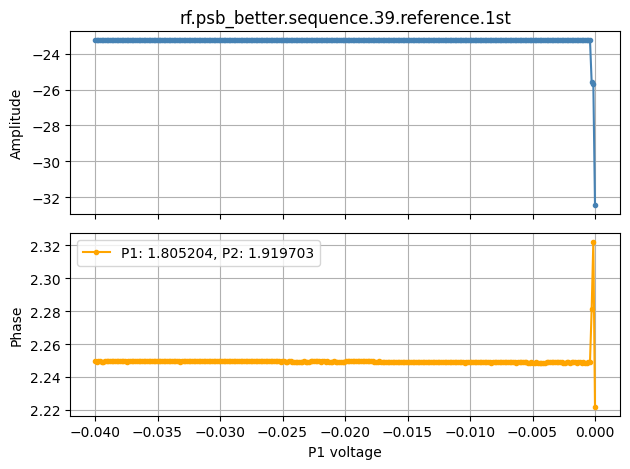

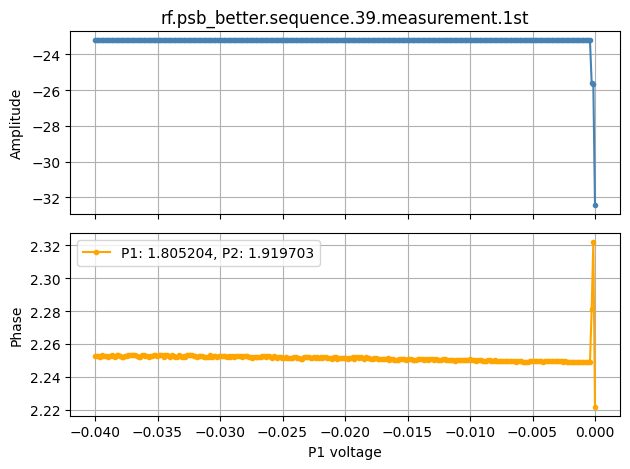

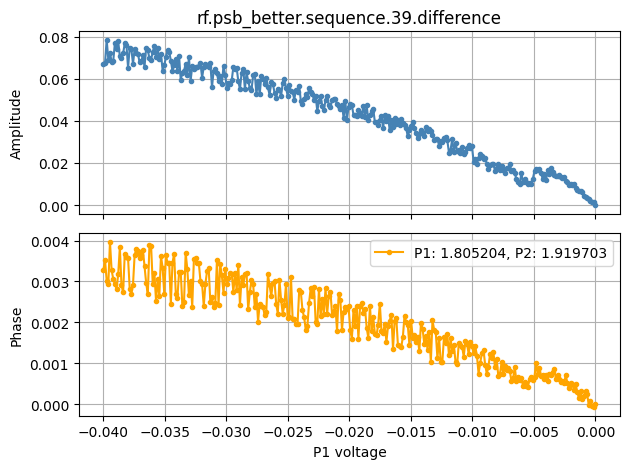

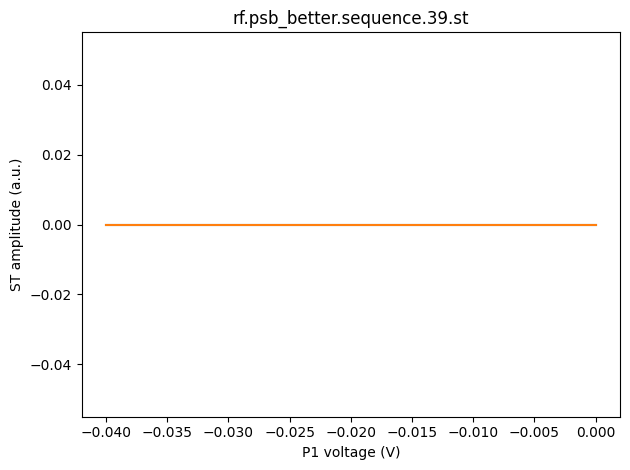

In [375]:
#si.P1(1.8052)
#si.P2(1.9197)

run_and_plot()

{'runid': 45, 'time_start': '2024-08-15 17:05:25.504759', 'time_end': '2024-08-15 17:50:40.751133', 'parameters': {'amplitude_volts': {'mixed_pulse': {'P1': 0.0, 'P2': -0.0}, 'measure_pulse_start': {'P1': 0.0, 'P2': -0.0, 'J': 0}, 'measure_pulse_end': {'P1': -0.04, 'P2': 0.04, 'J': 0.0}, 'p_ramp_rate': 0.00013}, 'dc_steps': {'start': 0.0, 'end': -0.04}, 'readout': {'freq': 406600000.0, 'gain': 0.95, 'time': 0.0001}, 'timings_sec': {'mixed initilise': 0.0006, 'read': 0.0001, 'settle': 0.003, 'trigger': 0.008, 'buffer': 1e-05, 'sampling_divider': 6}, 'feedback': {'target': -24.1, 'stepsize': 0, 'slope': -1}, 'powers': {'acq_in': 0, 'acq_out': -10, 'drive': 0}, 'averaging': {'seqc_averages': 1000, 'num_detuning': 300, 'num_j': 1}, 'gates': {'LCB': 0.150004, 'RCB': 0.150003, 'RG': 0.0, 'ResB': 0.0, 'P3': 0.0, 'P2': 1.919703, 'P1': 1.805204, 'SETB': 0.0, 'SRB': 0.929996, 'SLB': 0.930001, 'ST': 3.682114, 'bias': 0.0, 'VSS1P8': 0.0, 'VSS1P0': 0.0, 'VDD1P8': 1.800005, 'VDD1P0': 0.999996, 'VDD1

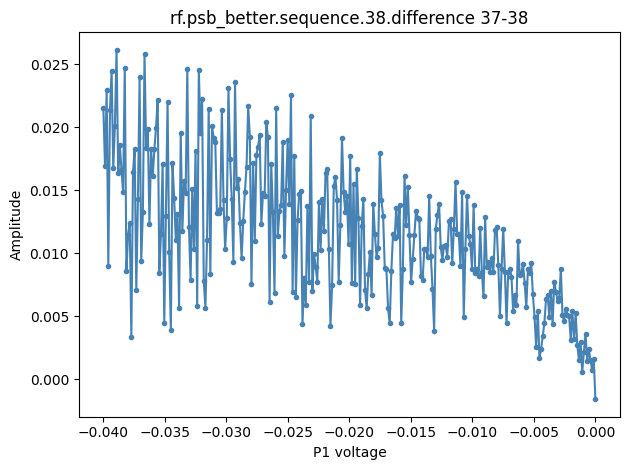

In [362]:
result1 = monty.loadrun("sequence.37")["data"]
result2 = monty.loadrun("sequence.38")["data"]

ref1 = result1[:, :, 0]
mes1 = result1[:, :, 1]

ref_amp1 = 10*np.log10(np.abs(ref1)**2/50*1000)
ref_phase1 = np.unwrap(np.angle(ref1))  # add axis for unwrap?

meas_amp1 = 10*np.log10(np.abs(mes1)**2/50*1000)
meas_phase1 = np.unwrap(np.angle(mes1))  # add axis for unwrap?



ref2 = result2[:, :, 0]
mes2 = result2[:, :, 1]

ref_amp2 = 10*np.log10(np.abs(ref2)**2/50*1000)
ref_phase2 = np.unwrap(np.angle(ref2))  # add axis for unwrap?

meas_amp2 = 10*np.log10(np.abs(mes2)**2/50*1000)
meas_phase2 = np.unwrap(np.angle(mes2))  # add axis for unwrap?

diff1 = meas_amp1[0] - ref_amp1[0]
diff2 = meas_amp2[0] - ref_amp2[0]

diffdiff = diff1 - diff2



fig, ax = plt.subplots()

ax.plot(p1_steps, diffdiff, ".-", color="steelblue")

ax.set_ylabel("Amplitude")
ax.set_title(monty.identifier + "." + monty.runname + ".difference 37-38")
ax.set_xlabel("P1 voltage")


plt.tight_layout()

monty.savefig(plt, "run 37-38 difference")